In [1]:
import pickle
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import mlab
import seaborn as sns
%matplotlib inline

mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

In [2]:
with open('/home/kazuki/^data_analysis/^Ecoli_Genome/Ecoli_Gene_TU.pickle','rb') as f:
    Gene_TU_dict = pickle.load(f)

In [3]:
polycistron_list = []
for key in Gene_TU_dict.keys():
    if type(Gene_TU_dict[key][4])==str:
        if '-' in Gene_TU_dict[key][4]:
            if Gene_TU_dict[key][4] not in polycistron_list:
                polycistron_list.append(Gene_TU_dict[key][4])

# get upstream genes
updown_dict = {}
for polycistron in polycistron_list:
    genes = polycistron.split('-')
    for gene in genes:
        if gene != genes[-1]:
            updown_dict[gene]=[gene]

# get downstream genes
for upstreamgene in updown_dict.keys():
    for polycistron in polycistron_list:
        genes = polycistron.split('-')
        x=0
        while x < len(genes):
            if genes[x]==upstreamgene:
                updown_dict[upstreamgene].append(genes[x+1])
            x+=1

# get distance
for upstreamgene in updown_dict.keys():
    downstreamgene = updown_dict[upstreamgene][1]
    if upstreamgene not in Gene_TU_dict.keys() or downstreamgene not in Gene_TU_dict.keys():
        continue
    if Gene_TU_dict[upstreamgene][0]=='+':
        upstreamgene_stop = int(Gene_TU_dict[upstreamgene][3])+1
        downstream_start = int(Gene_TU_dict[downstreamgene][2])
        distance = downstream_start-upstreamgene_stop
    if Gene_TU_dict[upstreamgene][0]=='-': 
        upstreamgene_stop = int(Gene_TU_dict[upstreamgene][2])
        downstream_start = int(Gene_TU_dict[downstreamgene][3])+1
        distance = upstreamgene_stop-downstream_start
    updown_dict[upstreamgene].append(distance)

In [5]:
df_base_CDS = pd.read_csv('rrf_CDS.csv')
df_base_CDS = df_base_CDS.loc[:,~df_base_CDS.columns.str.contains('^Unnamed')]

In [6]:
threshold = 0.05

updownratio_dict = {}
for f in ['ks'+str(x) for x in range(5,17)]:
    updownratio_dict[f]={}
    for upstreamgene in updown_dict.keys():
        downstreamgene = updown_dict[upstreamgene][1]
        if upstreamgene not in df_base_CDS['gene'].values or downstreamgene not in df_base_CDS['gene'].values:
            continue
        upstream_rpkm = df_base_CDS[df_base_CDS['gene']==upstreamgene][f+'_rpkm'].values
        downstream_rpkm = df_base_CDS[df_base_CDS['gene']==downstreamgene][f+'_rpkm'].values
        if df_base_CDS[df_base_CDS['gene']==upstreamgene][f+'_rpc'].values < threshold:
            continue
        if df_base_CDS[df_base_CDS['gene']==downstreamgene][f+'_rpc'].values < threshold:
            continue        
        if downstream_rpkm!=1:
            updownratio_dict[f][upstreamgene]=upstream_rpkm/downstream_rpkm

In [7]:
for key in updownratio_dict.keys():
    print len(updownratio_dict[key])

1227
1051
1152
1126
1247
1203
1362
1301
1123
875
1315
1307


In [8]:
ud_df = DataFrame.from_dict(updown_dict, orient='index')
ud_df.columns = ['up','down','distance']

for f in ['ks'+str(x) for x in range(5,17)]:
    ud_dict = updownratio_dict[f]
    ud_df_add = DataFrame.from_dict(ud_dict, orient='index')
    ud_df_add.columns = [f]
    ud_df = pd.concat([ud_df,ud_df_add],axis=1)

/home/kazuki/.pyenv/versions/anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


0.8870996187652116


([<matplotlib.axis.YTick at 0x7f7864549d50>,
 <a list of 3 Text yticklabel objects>)

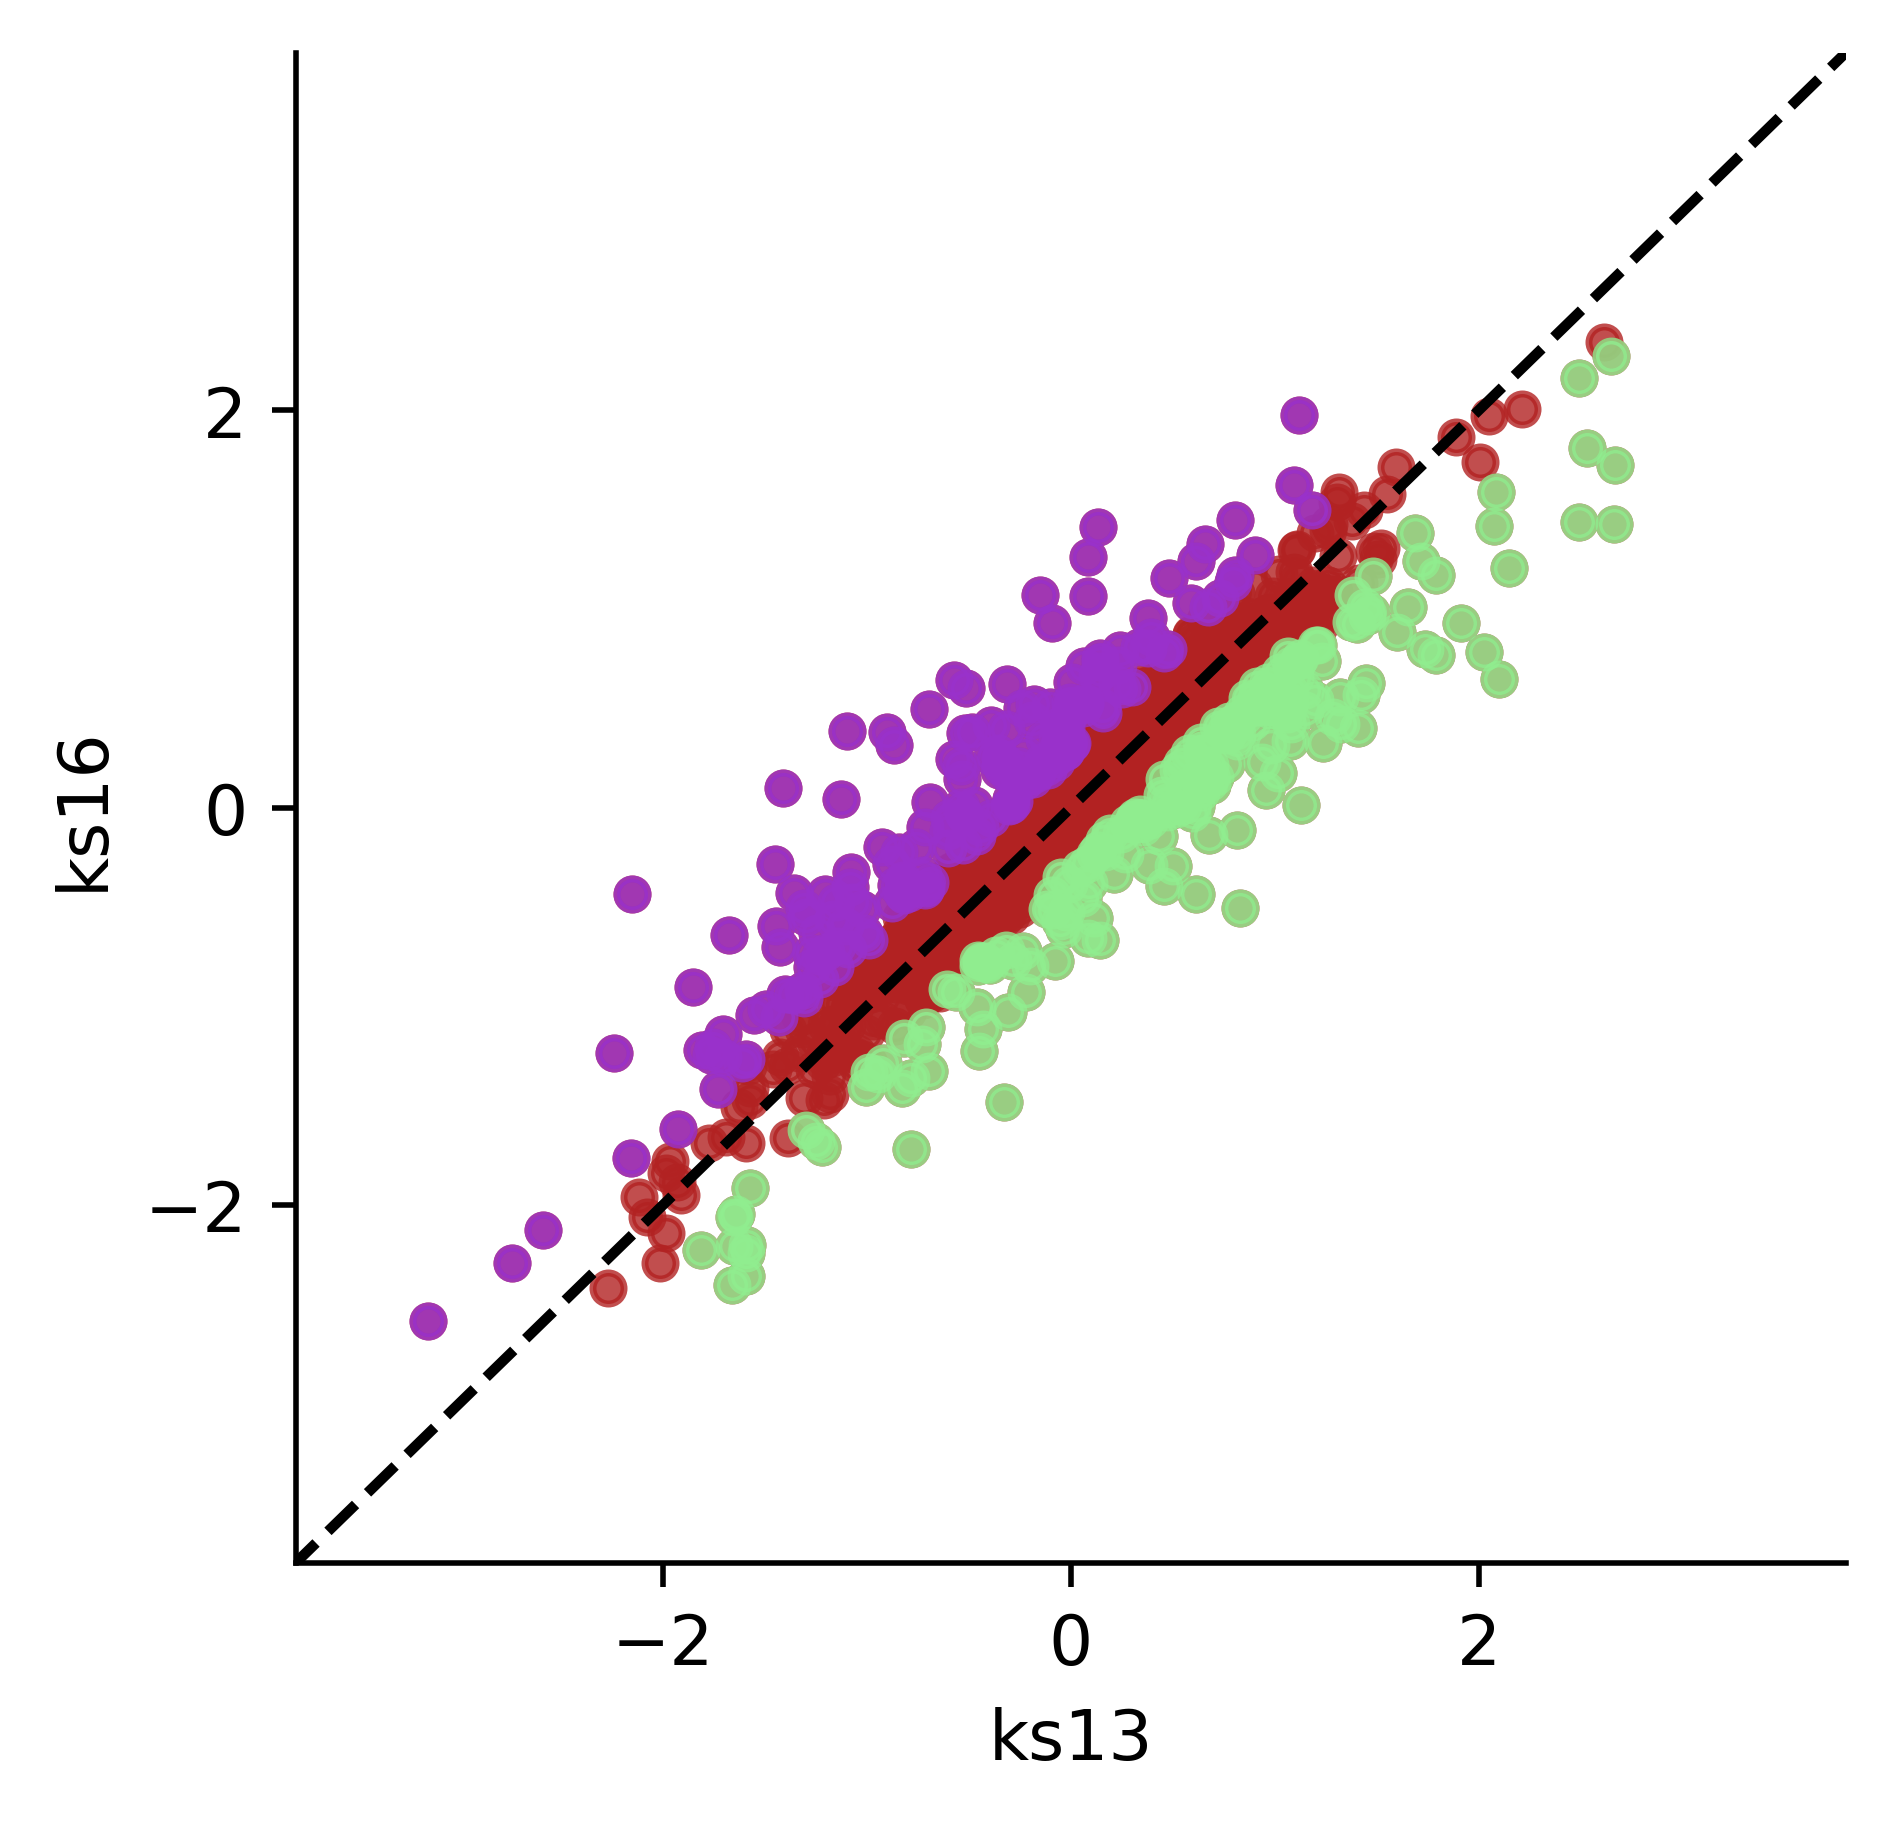

In [12]:
too_high=2


print ud_df['ks13'].apply(np.log10).replace([np.inf,-np.inf],np.nan).corr(ud_df['ks16'].apply(np.log10).replace([np.inf,-np.inf],np.nan))

fig, ax = plt.subplots()
fig.set_dpi(500)
fig.set_size_inches(4, 4) 
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()

ax = sns.regplot(x=ud_df['ks13'].apply(np.log10).replace([np.inf,-np.inf],np.nan),
                 y=ud_df['ks16'].apply(np.log10).replace([np.inf,-np.inf],np.nan),
                 fit_reg=False,
                color='firebrick',
                scatter_kws={'s': 20})

ax = sns.regplot(x=ud_df[ud_df['ks16']/ud_df['ks13']>too_high]['ks13'].apply(np.log10).replace([np.inf,-np.inf],np.nan),
                 y=ud_df[ud_df['ks16']/ud_df['ks13']>too_high]['ks16'].apply(np.log10).replace([np.inf,-np.inf],np.nan),
                 fit_reg=False,
                color='darkorchid',
                scatter_kws={'s': 20})

ax = sns.regplot(x=ud_df[ud_df['ks16']/ud_df['ks13']<(1.0/too_high)]['ks13'].apply(np.log10).replace([np.inf,-np.inf],np.nan),
                 y=ud_df[ud_df['ks16']/ud_df['ks13']<(1.0/too_high)]['ks16'].apply(np.log10).replace([np.inf,-np.inf],np.nan),
                 fit_reg=False,
                color='lightgreen',
                scatter_kws={'s': 20})

x = np.linspace(-5,5,100)
plt.plot(x, x, '--',color='black')

ax.set_xlim(-3.8,3.8)
ax.set_ylim(-3.8,3.8)
plt.xticks([-2,0,2])
plt.yticks([-2,0,2])
#plt.tick_params(labelsize=13)
#plt.savefig('fig_UD_sca.pdf', dpi=500, bbox_inches="tight", pad_inches=0.05)

0.8758558030255909


([<matplotlib.axis.YTick at 0x7f779d8aba10>,
 <a list of 3 Text yticklabel objects>)

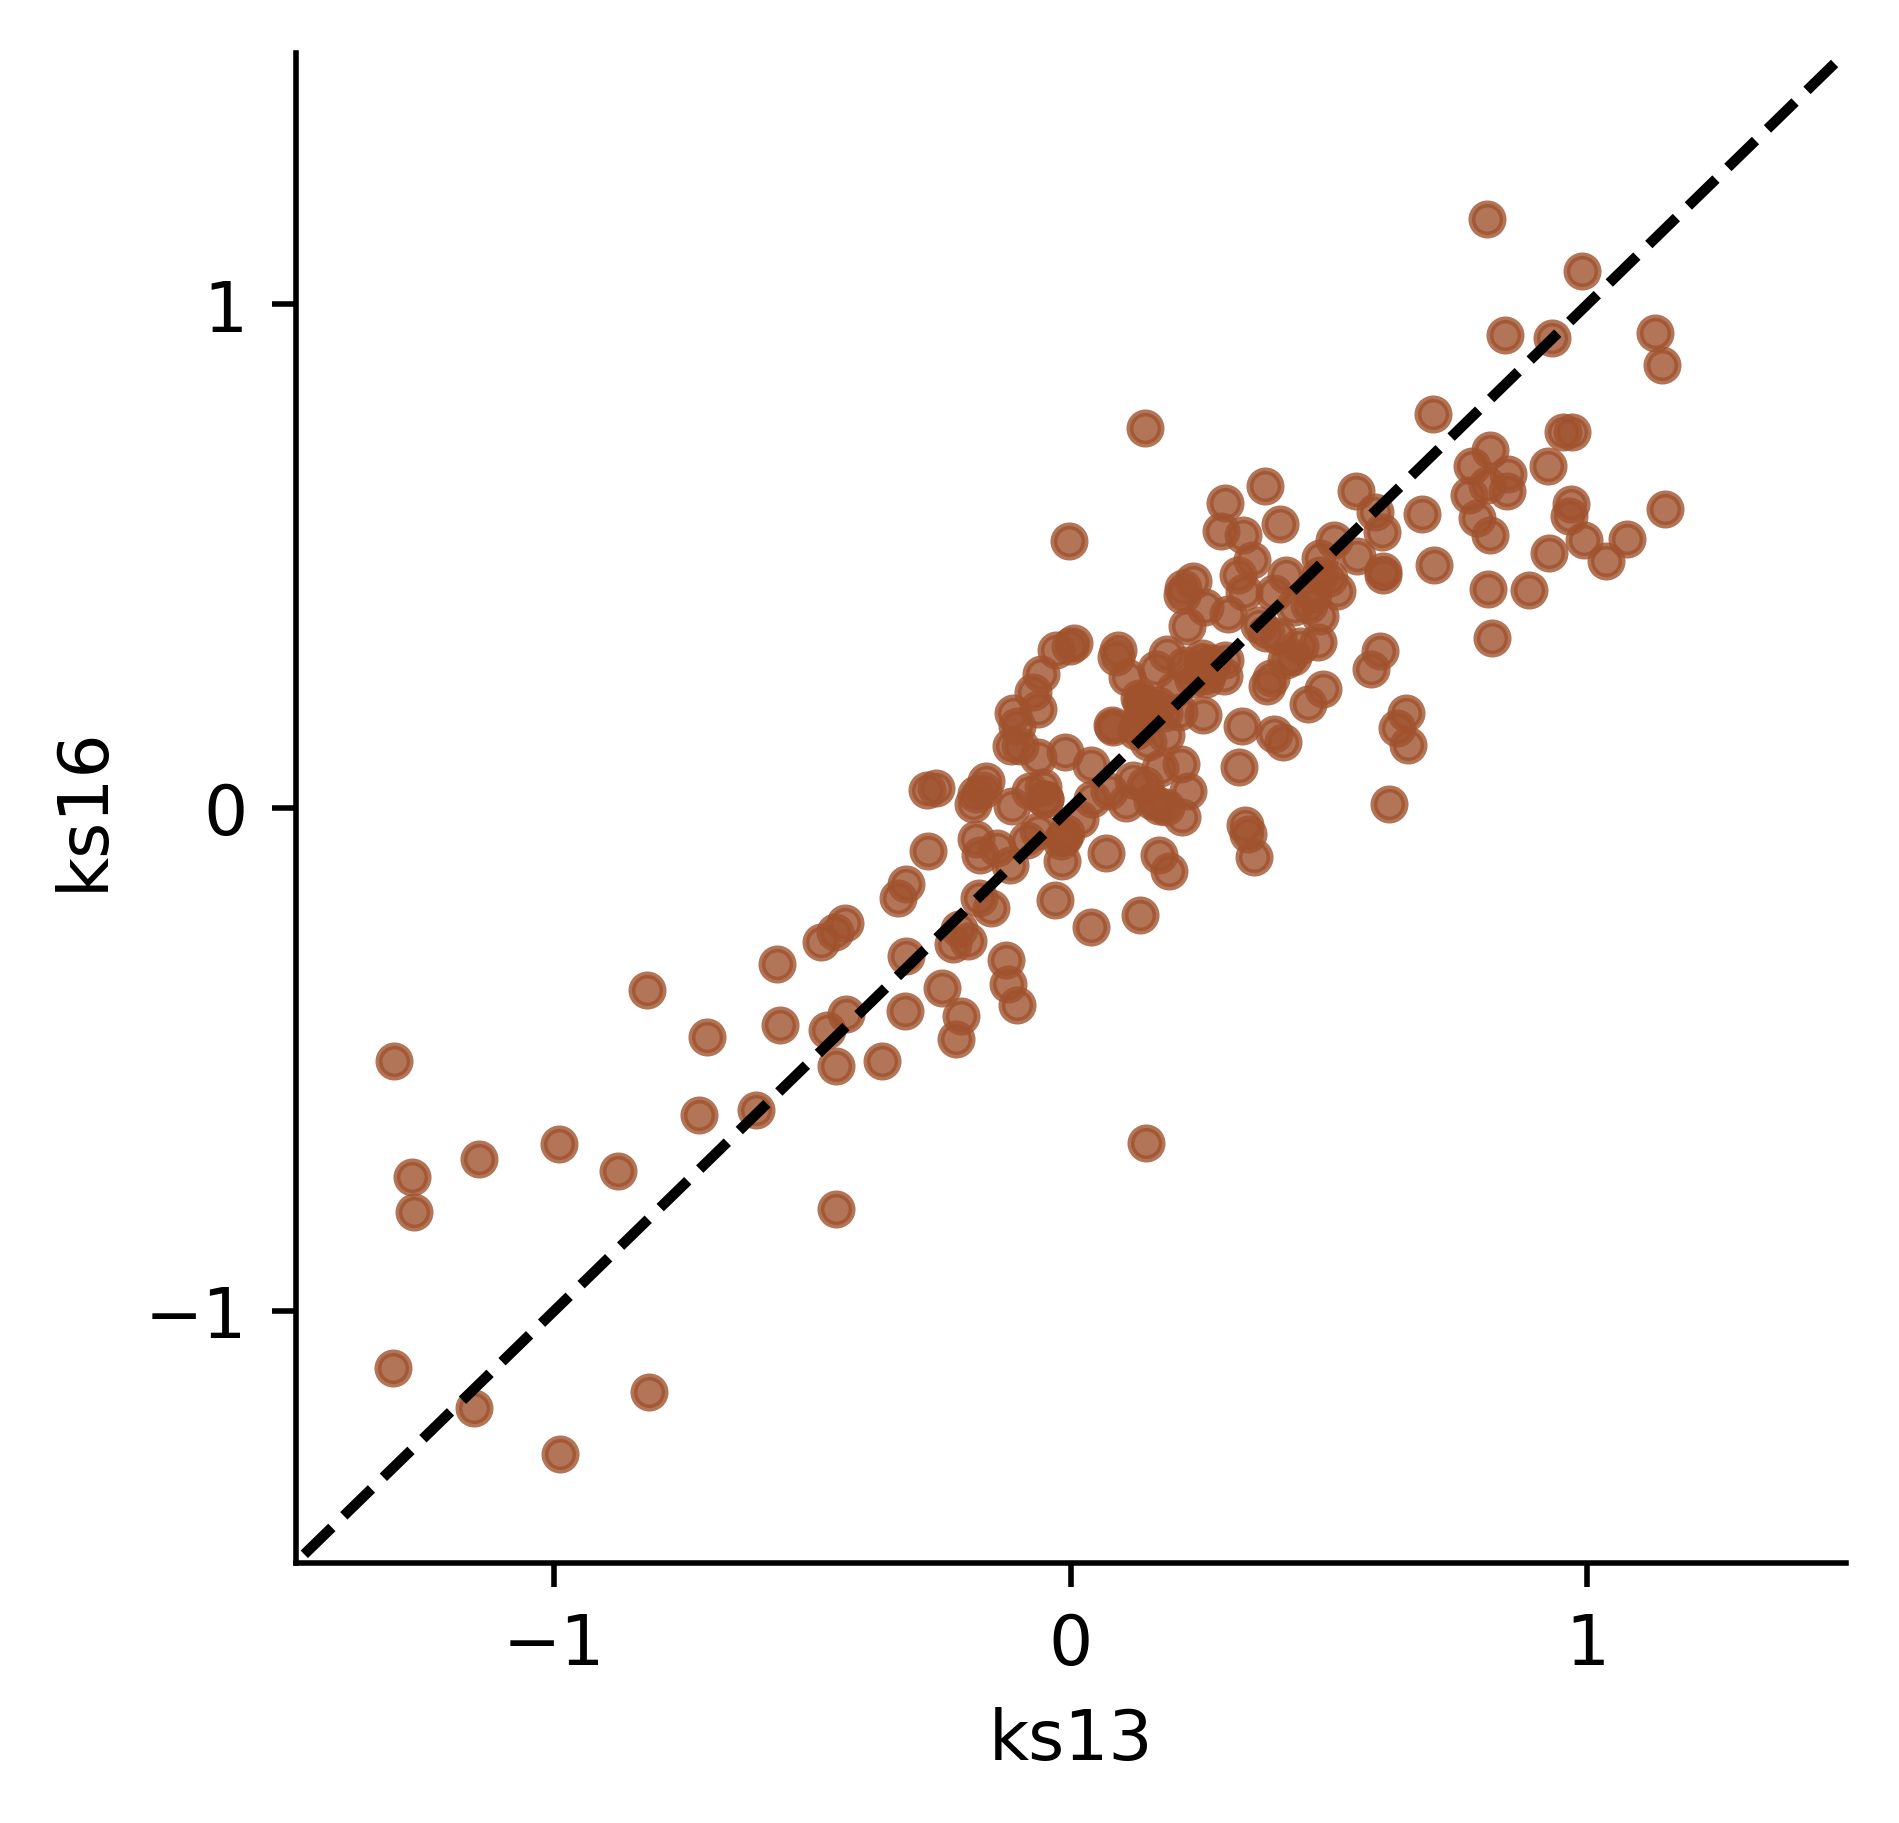

In [14]:
WT = 'ks13'
KD = 'ks16'

print ud_df[ud_df['distance'].isin([-1,-4])][WT].apply(np.log10).replace([np.inf,-np.inf],np.nan).corr(ud_df[ud_df['distance'].isin([-1,-4])][KD].apply(np.log10).replace([np.inf,-np.inf],np.nan))

fig, ax = plt.subplots()
fig.set_dpi(500)
fig.set_size_inches(4, 4) 
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()

ax = sns.regplot(x=ud_df[ud_df['distance']==-1][WT].apply(np.log10).replace([np.inf,-np.inf],np.nan),
                 y=ud_df[ud_df['distance']==-1][KD].apply(np.log10).replace([np.inf,-np.inf],np.nan),
                 fit_reg=False,
                color='sienna',
                scatter_kws={'s': 20}) 

ax = sns.regplot(x=ud_df[ud_df['distance']==-4][WT].apply(np.log10).replace([np.inf,-np.inf],np.nan),
                 y=ud_df[ud_df['distance']==-4][KD].apply(np.log10).replace([np.inf,-np.inf],np.nan),
                 fit_reg=False,
                color='sienna',
                scatter_kws={'s': 20}) 

x = np.linspace(-5,5,100)
plt.plot(x, x, '--',color='black')
#plt.plot(x, x+1, '--',color='red')
#plt.plot(x, x-1, '--',color='red')

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
#plt.tick_params(labelsize=13)
#plt.savefig('fig_UD_sca_4.pdf', dpi=500, bbox_inches="tight", pad_inches=0.05)

187
181


([<matplotlib.axis.YTick at 0x7f786442bb50>,
 <a list of 3 Text yticklabel objects>)

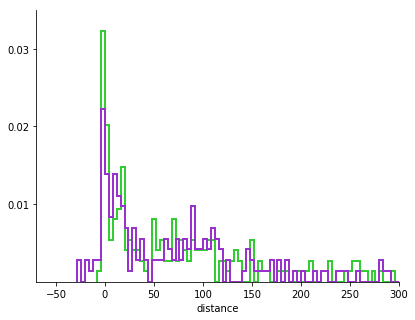

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(6.5, 5)  
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()


distribution=ud_df[ud_df['ks16']/ud_df['ks13']<(1.0/too_high)]['distance'].astype(int)
print len(distribution)
ax = sns.distplot(distribution, kde=False, color='linen',norm_hist=True,
             bins = [4*x for x in range(min(distribution)/4,max(distribution)/4)],
                 hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1, "color": "limegreen"})


distribution=ud_df[ud_df['ks16']/ud_df['ks13']>too_high]['distance'].astype(int)
print len(distribution)
ax = sns.distplot(distribution, kde=False, color='linen',norm_hist=True,
             bins = [4*x for x in range(min(distribution)/4,max(distribution)/4)],
                 hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1, "color": "darkorchid"})

plt.xlim(-70,300)
plt.xticks([-50,0,50,100,150,200,250,300])
plt.ylim(0,0.035)
plt.yticks([0.01,0.02,0.03])
#plt.savefig('fig_UD_distance.pdf', dpi=500, bbox_inches="tight", pad_inches=0.05)